In [1]:
import pickle
import hddCRP.behaviorDataHandlers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:

context_length = 2;
num_runs = 1;
runs = range(num_runs);
num_warmup_samples = 5000
num_samples        = 50000
overwrite_existing_results = False

simple_model = False
single_concentration = False
sequential_distances_only = True # if false, model setup more as a "smoother". If true, can simulate from the model

if(sequential_distances_only):
    results_directory = "Results/Pop/sequentialModel/"
else:
    results_directory = "Results/Pop/"
if(simple_model):
    results_directory += "simple/"
elif(single_concentration):
    results_directory += "singleAlpha/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

subjects_0 = list(data["data"].keys())





cc = 1;
prior_scales = {"alpha" : 5/cc, "tau_within" : 25, "tau_between" : 5}
prior_shapes = {"alpha" : 2*cc, "tau_within" :  2, "tau_between" : 2}


In [3]:
for subs in [1,2]:
    # subjects = ["A1"] subs = 2;
    if(subs != 0):
        subjects_id = np.array([True if xx.endswith(str(subs)) else False for xx in subjects_0])
        subjects = np.array(subjects_0)
        subjects = subjects[subjects_id]
    else:
        subjects = subjects_0
    subjects.sort()
    print("subjects = " + str(subjects))
    for run_idx in runs:
        print(f"RUN {run_idx}")
        filename = "{results_directory}/Subs_{subs}_context_{context_length}_run_{run_idx}.pkl".format(subs=subs, results_directory=results_directory, run_idx=run_idx, context_length=context_length)
        print(filename)
        if(not os.path.isfile(filename) or overwrite_existing_results):
            # for each run, should do some randomization of initial parameters (with known seeds so we can repeat everything)

            seed = subs * 1000 + run_idx;
            rng = np.random.Generator(np.random.MT19937(seed))

            models = [];
            for subject_idx, subject in enumerate(subjects):
                sequences = data["data"][subject]["data"]; # turns in each session
                session_types = data["data"][subject]["task"] # which maze

                ii = session_types.index("C")
                sequences = [sequences[ii]]
                session_types = [session_types[ii]]
                model = hddCRP.behaviorDataHandlers.create_hddCRP(sequences, session_types, rng = rng, 
                        sequential_distances_only=sequential_distances_only, depth=(context_length+1), include_timescales=(not simple_model))
                models += [model]
            tau_names = [str(xx) for xx in models[0].weight_param_labels]

            alphas_names = ["alpha_concentration_no_context", "alpha_concentration_one_back_context", "alpha_concentration_two_back_context"]
            alphas_names = alphas_names[:(context_length+1)]
            models, samples, step_size_settings = hddCRP.behaviorDataHandlers.sample_population_model_for_maze_data(models, num_samples=num_samples, num_warmup_samples=num_warmup_samples, 
                print_every=2500, single_concentration_parameter=single_concentration,  prior_shapes=prior_shapes, prior_scales=prior_scales)
        
            MCMC_info = {"step_size_settings" : step_size_settings.to_dict(),
                        "num_warmup_samples" : num_warmup_samples,
                        "num_samples" : num_samples,
                        "seed" : seed, 
                        "sequential_distances_only" : sequential_distances_only}
            samples["tau_parameter_names"] = tau_names
            samples["alphas_names"] = alphas_names
            samples["stats"] = [{"subject" : subjects[ii], "contexts" : models[ii]._groupings, "observations" : models[ii]._Y} for ii in range(len(subjects))]
            
            # save results to filename
            with open(filename, "wb") as results_file:
                results_data = {"MCMC_info" : MCMC_info,
                                "samples" : samples}
                pickle.dump(results_data, results_file)
                print("saved")

subjects = ['A1' 'B1' 'C1' 'D1' 'E1' 'F1' 'G1' 'H1' 'I1' 'J1']
RUN 0
Results/Pop/sequentialModel//Subs_1_context_2_run_0.pkl


NameError: name 'step_size_settings' is not defined

In [ ]:

taus = np.zeros((num_samples,1,len(runs),2))
alphas = np.zeros((num_samples,context_length+1,len(runs),2))

for run_idx in runs:
    for subs_idx, subs in enumerate([1,2]):
        filename = "{results_directory}/Subs_{subs}_context_{context_length}_run_{run_idx}.pkl".format(subs=subs, results_directory=results_directory, run_idx=run_idx, context_length=context_length)
    
        with open(filename, "rb") as file:
            results = pickle.load(file)

            ss = range(results["MCMC_info"]["num_warmup_samples"], results["MCMC_info"]["num_warmup_samples"]+results["MCMC_info"]["num_samples"])
            taus[:,:,run_idx,subs_idx] = np.exp(results["samples"]["log_taus"][ss,:])
            alphas[:,:,run_idx,subs_idx] = results["samples"]["alphas"][ss,:]


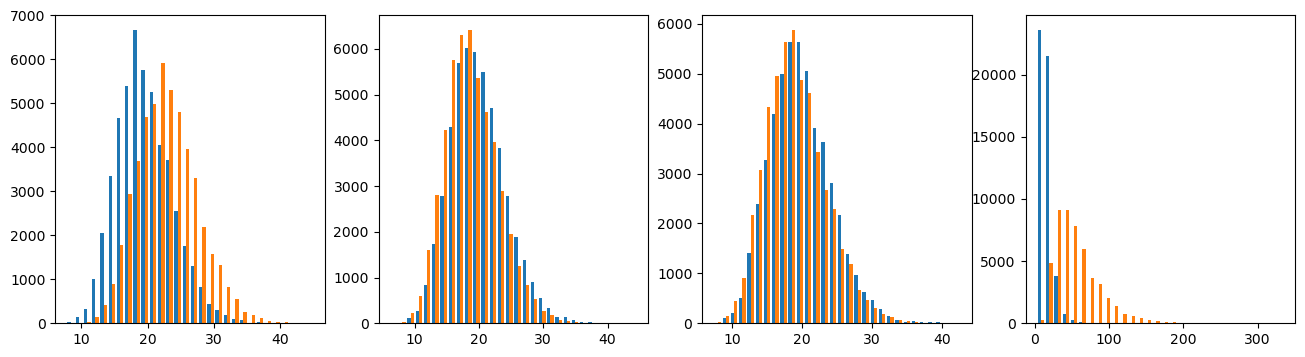

In [ ]:
run_idx = 0;
plt.figure(figsize=(16,4))
for ii in range(alphas.shape[1]):
    plt.subplot(1,4,ii+1)
    plt.hist(np.squeeze(alphas[:,ii,run_idx,:]),30)
plt.subplot(1,4,4)
plt.hist(np.squeeze(taus[:,:,run_idx,:]),30);


In [ ]:
from scipy.stats.mstats import gmean
a2 = alphas[:,:,run_idx,1];
a1 = alphas[:,:,run_idx,0];

# a1[:,0] = a1[:,0] - np.mean(a1[:,1:],axis=1)
# a2[:,0] = a2[:,0] - np.mean(a2[:,1:],axis=1)

t2 = taus[:,0,run_idx,1];
t1 = taus[:,0,run_idx,0];

# t1 = np.mean(a1,axis=1)
# t2 = np.mean(a2,axis=1)
# t1 = gmean(a1,axis=1)
# t2 = gmean(a2,axis=1)

a1c = a1.copy()
a2c = a2.copy()

NA = alphas.shape[1];
a1c[:,:] = a1c[np.random.permutation(a1c.shape[0]),:]
a2c[:,:] = a2c[np.random.permutation(a2c.shape[0]),:]
# for ii in range(NA):
#     a1c[:,ii] = np.random.permutation(a1[:,ii])
#     a2c[:,ii] = np.random.permutation(a2[:,ii])
ac = a2c > a1c;
print(np.mean(ac,axis=0))



# pp = np.zeros((2,) * NA)
# for ii in range(2):
#     if(ii == 0):
#         ac0 = ac[:,0]
#     else:
#         ac0 = 1-ac[:,0]

#     for jj in range(2):
#         if(jj == 0):
#             ac1 = ac[:,1]
#         else:
#             ac1 = 1-ac[:,1]

#         for kk in range(2):
#             if(kk == 0):
#                 ac2 = ac[:,2]
#             else:
#                 ac2 = 1-ac[:,2]

#             pp[ii,jj,kk] = np.mean(ac0 & ac1 & ac2)

pp = np.zeros((NA,NA))
for ii in range(NA):
    ac0 = ac[:,ii]
    for jj in range(NA):
        ac1 = ac[:,jj]

        ac2 = ac[ac0 >= ac1, ~np.isin(np.arange(NA), [ii,jj])];
        pp[ii,jj] = np.mean(ac2)
    
t1c = np.random.permutation(t1)
t2c = np.random.permutation(t2)
print(np.mean(t2c > t1c))

print(pp)

NameError: name 'alphas' is not defined

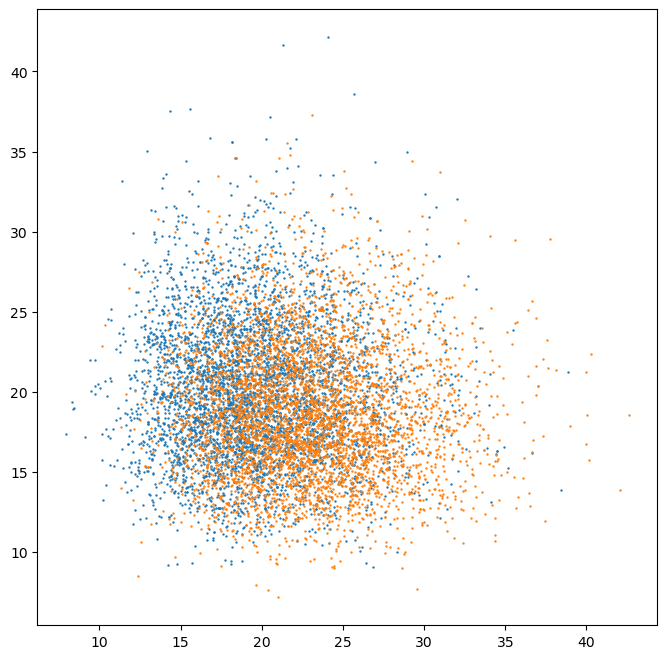

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(a1[::10,0],a1[::10,1],s=0.5)
plt.scatter(a2[::10,0],a2[::10,1],s=0.5)